## Tacotron 2 inference code 
Edit the variables **checkpoint_path** and **text** to match yours and run the entire code to generate plots of mel outputs, alignments and audio synthesis from the generated mel-spectrogram using Griffin-Lim.

#### Import libraries and setup matplotlib

In [1]:
import matplotlib
%matplotlib inline
import matplotlib.pylab as plt

import IPython.display as ipd

import sys
sys.path.append('waveglow/')
import numpy as np
import torch

from hparams import create_hparams
from model import Tacotron2
from layers import TacotronSTFT, STFT
from audio_processing import griffin_lim
from train import load_model
from text import text_to_sequence, sequence_to_text
from denoiser import Denoiser
import librosa

/home/trinhan/anaconda3/envs/viTTS/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:493: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/trinhan/anaconda3/envs/viTTS/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:494: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/trinhan/anaconda3/envs/viTTS/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:495: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/trinhan/anaconda3/envs/viTTS/lib/python3

In [2]:
print("Hello world")

Hello world


In [3]:
def plot_data(data, figsize=(16, 4)):
    fig, axes = plt.subplots(1, len(data), figsize=figsize)
    for i in range(len(data)):
        axes[i].imshow(data[i], aspect='auto', origin='bottom', 
                       interpolation='none')

#### Setup hparams

In [4]:
from hparams import create_hparams
hparams = create_hparams()
hparams.sampling_rate = 22050
hparams.max_decoder_steps=20000
#hparams.gate_threshold = 0.02 #could prevent maximum decoder step
#hparams.gate_threshold = 0.0

#### Load model from checkpoint

In [5]:
waveglow_path = 'waveglow_256channel.pt'
waveglow = torch.load(waveglow_path)['model']
waveglow.cuda().eval().half()
for k in waveglow.convinv:
    k.float()
denoiser = Denoiser(waveglow)

In [6]:
#checkpoint_path = "outdir_vlsp_nopre2/checkpoint_120000"
checkpoint_path = "best_checkpoint/checkpoint_54000"
model = load_model(hparams)
model.load_state_dict(torch.load(checkpoint_path)['state_dict'])
_ = model.cuda().eval().half()

#### Load WaveGlow for mel2audio synthesis and denoiser

In [7]:
from viphoneme import syms, vi2IPA_split
import re


text = "giải phóng không gian"

delimit="/"
text=re.sub(re.compile(r'\s+'), ' ', text)
text=text.rstrip(".").rstrip("?").rstrip("!").rstrip(" ")
ipa = vi2IPA_split(text,delimit)
text=ipa.replace("/'","")
print(text)


#Try with english to IPA
#text="/s/t/r/ɪ/ŋ/5/ /s/ɛ/n/5/ /t/ə/n/s/1/ /ɪ/g/1/ /z/æ/m/5/ /p/ə/l/z/1/ /s/ə/m/5/ /`/w/ʌ/n/1/ /t/r/a/ɪ/d/5/ /t/u/1/ /s/t/r/ɪ/ŋ/5/ /h/ɪ/m/1/ /ð/ə/1/ /v/a/ɪ/5/ /ə/5/ /l/ɪ/n/5/ /s/t/r/ɪ/ŋ/5/ /ɪ/z/5/ /f/ɛ/s/t/5/ /d/r/ɔ/n/5/ /a/n/1/ /w/ʌ/n/1/ /s/a/ɪ/d/5/ /e/ɪ/1/ /p/i/s/5/ /ʌ/v/1/ /s/t/r/ɪ/ŋ/5/ /ʃ/i/5/ /f/a/ʊ/n/d/5/ /ɪ/n/1/ /ð/ə/1/ /k/ɪ/5/ /ʧ/ə/n/1/ /w/ʊ/d/5/ /s/ə/1/ /f/a/ɪ/s/5"


#seque=text_to_sequence(text, ['basic_cleaners'])
#print(seque)
#print(sequence_to_text(seque,"/"))

------------------------------------------------------
/home/trinhan/anaconda3/envs/viTTS/lib/python3.6/site-packages/vinorm
------------------------------------------------------
Text normalize:               giải phóng không gian
Vietnamese Tokenize:          ['giải phóng', 'không gian']
IPA Vietnamese:              /j/a/j/4/_/f/ɔ/ŋ͡m/5/ /x/o/ŋ͡m/1/_/j/a/n/1/ 
------------------------------------------------------
/j/a/j/4/_/f/ɔ/ŋ͡m/5/ /x/o/ŋ͡m/1/_/j/a/n/1/ /./


In [8]:
print(text)

/j/a/j/4/_/f/ɔ/ŋ͡m/5/ /x/o/ŋ͡m/1/_/j/a/n/1/ /./


#### Prepare text input

In [9]:
sequence = np.array(text_to_sequence(text, ['basic_cleaners']))[None, :]
sequence = torch.autograd.Variable(
    torch.from_numpy(sequence)).cuda().long()

#### Decode text input and plot results

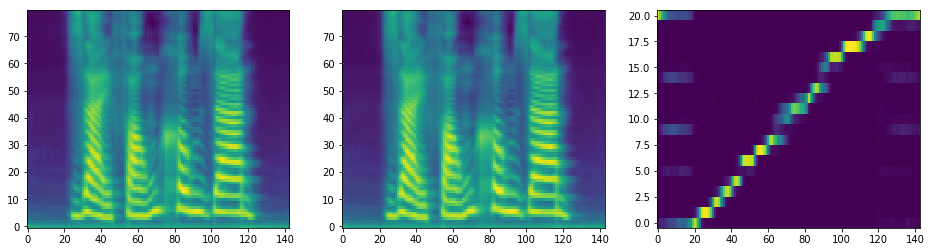

In [10]:
mel_outputs, mel_outputs_postnet, _, alignments = model.inference(sequence)

print(type(mel_outputs))

plot_data((mel_outputs.float().data.cpu().numpy()[0],
           mel_outputs_postnet.float().data.cpu().numpy()[0],
           alignments.float().data.cpu().numpy()[0].T))



In [11]:
print(mel_outputs_postnet.type())

#### Synthesize audio from spectrogram using WaveGlow

In [12]:
with torch.no_grad():
    audio = waveglow.infer(mel_outputs_postnet, sigma=0.666)
ipd.Audio(audio[0].data.cpu().numpy(), rate=22050)

In [13]:
#librosa.output.write_wav("DATA/test.wav", audio[0].data.cpu().numpy().T, 22050)
import soundfile
soundfile.write("DATA/test.wav", audio[0].data.cpu().numpy().astype("float32"), 22050)
tmp_audio, sf = librosa.load("DATA/test.wav", 16000)
ipd.Audio(tmp_audio, rate=sf)

soundfile.write("DATA/test_2.wav", tmp_audio, sf)

In [14]:
## test load audio
test_audio, sr = soundfile.read("DATA/test_2.wav")
sr
ipd.Audio(test_audio, rate=sr)

# Voice Conversion

In [15]:
sys.path.append('../../../VoiceConversion/autovc/')
sys.path.append('../../../VoiceConversion/autovc/speaker_verification')

In [16]:
from taco_inference import generateAudio, get_verification_pytorch, generateAudioGroup

In [17]:
np.sum(get_verification_pytorch("../../../VoiceConversion/autovc/vn_wavs/2/6.wav"))

-0.8865335931041045

In [ ]:
wave_form = generateAudio("DATA/test_2.wav", "DATA/test_2.wav", "../../../VoiceConversion/autovc/checkpoints_wided_addnoise_final/autovc_250000.pt", "../../../VoiceConversion/checkpoint_step001000000_ema.pth")

 53%|█████▎    | 14209/26624 [06:09<05:22, 38.46it/s]

In [20]:
ipd.Audio(wave_form, rate=16000)

In [37]:
wave_form_2 = generateAudio("DATA/test_2.wav" ,"../../../VoiceConversion/vivos_only_wavs/VIVOSSPK24/VIVOSSPK24_001.wav","../../../VoiceConversion/autovc/checkpoints_wided_addnoise_final/autovc_250000.pt", "../../../VoiceConversion/checkpoint_step001000000_ema.pth")

100%|██████████| 49664/49664 [21:46<00:00, 38.00it/s]


In [38]:
ipd.Audio(wave_form_2, rate=16000)

In [ ]:
wave_form_3 = generateAudioGroup("DATA/test_2.wav" ,"../../../VoiceConversion/vivos_only_wavs/VIVOSDEV55/","../../../VoiceConversion/autovc/checkpoints_wided_addnoise_final/autovc_250000.pt", "../../../VoiceConversion/checkpoint_step001000000_ema.pth")
ipd.Audio(wave_form_3, rate=16000)

 92%|█████████▏| 25531/27648 [11:13<00:57, 37.14it/s]

In [19]:
wave_form_4 = generateAudio("DATA/test_2.wav" ,"../../../VoiceConversion/vctk_dataset/normalized/p278/p278_400_mic1.flac","../../../VoiceConversion/autovc/checkpoints_wided_addnoise_final/autovc_250000.pt", "../../../VoiceConversion/checkpoint_step001000000_ema.pth", english=True)
ipd.Audio(wave_form_4, rate=16000)

In [21]:
ipd.Audio(wave_form_4, rate=16000)

###  Remove WaveGlow bias

In [20]:
audio_denoised = denoiser(audio,
                          strength=0.01)[:, 0]
ipd.Audio(audio_denoised.cpu().numpy(), rate=hparams.sampling_rate) 

###  Speech up voice for natural

In [ ]:
audio_denoised = denoiser(audio, strength=0.01)[:, 0]

ipd.Audio(audio_denoised.cpu().numpy().astype(float), rate=22050) 

librosa.output.write_wav("DATA/test.wav", audio_denoised.cpu().numpy().T, 22050)

###  Reduce noise 

In [ ]:
def detect_leading_silence(sound, silence_threshold=-50.0, chunk_size=10):
    '''
    sound is a pydub.AudioSegment
    silence_threshold in dB
    chunk_size in ms

    iterate over chunks until you find the first one with sound
    '''
    trim_ms = 0 # ms

    assert chunk_size > 0 # to avoid infinite loop
    while sound[trim_ms:trim_ms+chunk_size].dBFS < silence_threshold and trim_ms < len(sound):
        trim_ms += chunk_size

    return trim_ms

In [ ]:
import noisereduce as nr

# load data
#data = audio_denoised.cpu().numpy()
audio_denoised = audio.cpu().numpy()
audio_denoised = librosa.to_mono(audio_denoised)

#librosa.output.write_wav("DATA/DEMO/data.wav", data, 24000) 
# select section of data that is noise
noisy_part = audio_denoised

#noisy_part = data
# perform noise reduction
print(noisy_part.shape)
reduced_noise = nr.reduce_noise(audio_clip=audio_denoised, noise_clip=audio_denoised, verbose=True)


#ipd.Audio(audio_denoised.cpu().numpy(), rate=24000) 
#trimmed_noise, index = librosa.effects.trim(reduced_noise, top_db=100000000)
#detect_leading_silence(reduced_noise)

#print(trimmed_noise)



ipd.Audio(reduced_noise, rate=23000) 
#librosa.output.write_wav("audio/reduce.wav", reduced_noise, 23000) 

In [ ]:
!conda install -c conda-forge ipywidgets

###  Check all checkpoint

In [ ]:
#Test all checkpoint # Bullshit Idea
'''waveglow_path = 'waveglow_256channel.pt'
waveglow = torch.load(waveglow_path)['model']
waveglow.cuda().eval().half()
for k in waveglow.convinv:
    k.float()
denoiser = Denoiser(waveglow)


from viphoneme import syms, vi2IPA_split
import re
text = "Về diễn biến sức khỏe của 2 bệnh nhân nặng, Tiểu Ban điều trị cho biết trong đó bệnh nhân số 19 đang điều trị tại Bệnh viện Bệnh Nhiệt đới TW cơ sở Đông Anh đã chuyển sang trạng thái nặng"
delimit="/"
text=re.sub(re.compile(r'\s+'), ' ', text)
text=text.rstrip(".").rstrip("?").rstrip("!").rstrip(" ")
ipa = vi2IPA_split(text,delimit)
text=ipa
seque=text_to_sequence(text, ['basic_cleaners'])
'''
import noisereduce as nr


for ii in  range(114000,134000,1000):
    checkpoint_path = "outdir_vlsp_nopre/checkpoint_"+str(ii)
    model = load_model(hparams)
    model.load_state_dict(torch.load(checkpoint_path)['state_dict'])
    _ = model.cuda().eval().half()

    sequence = np.array(text_to_sequence(text, ['basic_cleaners']))[None, :]
    sequence = torch.autograd.Variable(
        torch.from_numpy(sequence)).cuda().long()

    mel_outputs, mel_outputs_postnet, _, alignments = model.inference(sequence)

    with torch.no_grad():
        audio = waveglow.infer(mel_outputs_postnet, sigma=0.666)
    audio_denoised = denoiser(audio, strength=0.01)[:, 0] 
       
    audio_denoised = audio.cpu().numpy()
    audio_denoised = librosa.to_mono(audio_denoised)

    noisy_part = audio_denoised
    reduced_noise = nr.reduce_noise(audio_clip=audio_denoised, noise_clip=noisy_part, verbose=False)
    
    #ipd.display(ipd.Audio(reduced_noise, 23000))
    
    
    librosa.output.write_wav("DATA/Value/"+str(ii)+".wav",reduced_noise, 23000) 

    #ipd.Audio(audio_denoised.cpu().numpy(), rate=hparams.sampling_rate) 
    

#Good at 115k  26 35

In [ ]:
#Test all checkpoint # Bullshit Idea
'''waveglow_path = 'waveglow_256channel.pt'
waveglow = torch.load(waveglow_path)['model']
waveglow.cuda().eval().half()
for k in waveglow.convinv:
    k.float()
denoiser = Denoiser(waveglow)


from viphoneme import syms, vi2IPA_split
import re
text = "Về diễn biến sức khỏe của 2 bệnh nhân nặng, Tiểu Ban điều trị cho biết trong đó bệnh nhân số 19 đang điều trị tại Bệnh viện Bệnh Nhiệt đới TW cơ sở Đông Anh đã chuyển sang trạng thái nặng"
delimit="/"
text=re.sub(re.compile(r'\s+'), ' ', text)
text=text.rstrip(".").rstrip("?").rstrip("!").rstrip(" ")
ipa = vi2IPA_split(text,delimit)
text=ipa
seque=text_to_sequence(text, ['basic_cleaners'])
'''
import noisereduce as nr


for ii in  range(1000,10000,1000):
    checkpoint_path = "outdir_vlsp_nopre/checkpoint_"+str(ii)
    model = load_model(hparams)
    model.load_state_dict(torch.load(checkpoint_path)['state_dict'])
    _ = model.cuda().eval().half()

    sequence = np.array(text_to_sequence(text, ['basic_cleaners']))[None, :]
    sequence = torch.autograd.Variable(
        torch.from_numpy(sequence)).cuda().long()

    mel_outputs, mel_outputs_postnet, _, alignments = model.inference(sequence)

    with torch.no_grad():
        audio = waveglow.infer(mel_outputs_postnet, sigma=0.666)
    audio_denoised = denoiser(audio, strength=0.01)[:, 0] 
       
    #audio_denoised = audio_denoised.cpu().numpy()
    #audio_denoised = librosa.to_mono(audio_denoised)

    
    #librosa.output.write_wav("DATA/Value/"+str(ii)+".wav",audio_denoised, 22500) 
    ipd.Audio(audio_denoised.cpu().numpy(), rate=hparams.sampling_rate) 
    

#Good at 115k  26 35

###  Export 100 test cases

In [ ]:
import noisereduce as nr
import librosa
import re


def audio_generate(text, path):
    
    delimit="/"
    text=re.sub(re.compile(r'\s+'), ' ', text)
    text=text.rstrip(".").rstrip("?").rstrip("!").rstrip(" ")
    #print(text)
    ipa = vi2IPA_split(text,delimit)

    text=ipa
    
    
    seque=text_to_sequence(text, ['basic_cleaners'])
    sequence = np.array(text_to_sequence(text, ['basic_cleaners']))[None, :]
    sequence = torch.autograd.Variable(torch.from_numpy(sequence)).cuda().long()
    mel_outputs, mel_outputs_postnet, _, alignments = model.inference(sequence)
    
    with torch.no_grad():
        audio = waveglow.infer(mel_outputs_postnet, sigma=0.666)
    audio_denoised = denoiser(audio,strength=0.01)[:, 0]
    
    librosa.output.write_wav("DATA/VIVOS/{}.wav".format(path), audio_denoised.cpu().numpy().T, 22050)
    

import warnings
warnings.filterwarnings('ignore')

    
    
def generateData():
    
    with open("best_checkpoint/metadata.txt") as texts:
        
        for line in texts.readlines():
    
            path, text = line.split("|")
            #filelist=filelist[cons:]
            
            audio_generate(text,path)
        
        


In [ ]:
generateData()

In [ ]:
for i, data in enumerate(data):
    print(i)
    print(data)

In [ ]:
những hành động vui đùa quá trớn của thú cưng đôi khi khiến chủ nhân của chúng rơi vào tình cảnh dở khóc dở cười
xác minh hồ sơ của đối tượng gặp mặt qua đó sẽ rút ngắn thời gian tìm hiểu đảm bảo điều kiện gia đình và dễ dàng tiến đến hôn nhân hơn
mật ong hỗ trợ dưỡng ẩm cho da và nâng cao sự đàn hồi của da căng mịn làn da cũng như giúp tăng cường sức sống và giảm mụn viêm sưng
các tế bào gốc có thể mở ra hướng điều trị mới cho bệnh nhân bị suy tim
theo ông quan điểm của chính phủ là tạo môi trường kinh doanh thông thoáng công khai minh bạch nhưng với điều kiện là phải đảm bảo môi trường bền vững
bắt buộc phải quan tâm trị liệu dứt điểm chứng bệnh ngay khi có biểu hiện để lâu dễ phát triển thành mãn tính và vô cùng khó chữa trị
chà bột cà chua lên làn da thô ráp của bạn giúp se lỗ chân lông tái tạo và làm săn da mặt
trước hết nhan đề làm nổi bật hình ảnh trong toàn bài đó là những chiếc xe không kính hay chính là hiện thực khốc liệt của cuộc chiến tranh
đặc biệt vào những ngày lễ tết dù bận công việc đến mấy nữ ca sĩ này vẫn luôn dành thời gian gửi quà và gọi điện về chúc mừng mẹ chồng
hầu hết những nhà cung cấp các phần mềm kế toán sẽ chỉ cho phép người dùng sử dụng chúng miễn phí trong một khoảng thời gian nhất định
chiếc xe tải lao vào đám đông khiến hàng trăm người bỏ chạy trong khi cảnh sát có vũ trang được điều động tới hiện trường được cho đã nổ súng
các chàng trai hy vọng có thể dùng chính sức trẻ của mình để giúp các em nhỏ những người nghèo vượt qua những khó khăn trong khả năng cho phép
hay nói cách khác việc chúng ta sinh ra mang trong mình xu hướng giới tính như thế nào là do tự nhiên tạo hóa vốn sinh ra đã như vậy
theo quan niệm của nhiều người ngành công nghiệp điện tử lâu nay vẫn được xem là ngành công nghiệp ít nguy cơ hay còn gọi là ngành công nghiệp sạch
người dân nơi đây đã được hưởng đầy đủ các chính sách hỗ trợ của nhà nước họ yên tâm ra khơi bám biển đánh bắt cá tôm
và nhắc nhở chẩn đoán đưa ra liệu pháp chữa trị thích hợp cho bệnh nhân
đồng thời tăng cường tuyên truyền trên các phương tiện thông tin đại chúng để nâng cao ý thức tiết kiệm điện của cộng đồng xã hội và doanh nghiệp
chúng tôi sẽ ngăn chặn sự lan rộng và việc sử dụng vũ khí hóa học
chiến trường chủ yếu ở hai bờ sông gianh vùng nghệ an hà tĩnh và quảng bình ngày nay
hầu hết hàng hóa lưu thông trên thị trường đều cần phải có mã vạch


In [ ]:
def getfiles(DATA):
    DATA=DATA.split('\n\n')
    data= [d.split("|")[1] for d in DATA]
    print("\n".join(data))
    return data

def generateData(filelist,cons):
    filelist=filelist[cons:]
    for index,text in enumerate(filelist):
        audio_generate(text,index+cons)
        

for i in check point():
    generateData(["giải phóng không gian này là xu hướng tất yếu nhưng vì tư duy tiểu nông đã bám rễ vào quan niệm nhiều người nên cuộc chiến không hề dễ dàng"],0)
    
def audio_generate_checkpoint(text,index):

    delimit="/"
    text=re.sub(re.compile(r'\s+'), ' ', text)
    text=text.rstrip(".").rstrip("?").rstrip("!").rstrip(" ")
    #print(text)
    ipa = vi2IPA_split(text,delimit)

    text=ipa


    seque=text_to_sequence(text, ['basic_cleaners'])
    sequence = np.array(text_to_sequence(text, ['basic_cleaners']))[None, :]
    sequence = torch.autograd.Variable(torch.from_numpy(sequence)).cuda().long()
    mel_outputs, mel_outputs_postnet, _, alignments = model.inference(sequence)

    with torch.no_grad():
        audio = waveglow.infer(mel_outputs_postnet, sigma=0.666)
    audio_denoised = denoiser(audio,strength=0.01)[:, 0]

    audio_denoised = audio.cpu().numpy()
    audio_denoised = librosa.to_mono(audio_denoised)

    #librosa.output.write_wav("DATA/DEMO/data.wav", data, 24000) 
    # select section of data that is noise
    noisy_part = audio_denoised

    #noisy_part = data
    # perform noise reduction
    #print(noisy_part.shape)
    reduced_noise = nr.reduce_noise(audio_clip=audio_denoised, noise_clip=noisy_part, verbose=False)

    # load data
    #data = audio_denoised.cpu().numpy()
    # select section of data that is noise
    #noisy_part = data[1000:2000]
    # perform noise reduction
    #reduced_noise = nr.reduce_noise(audio_clip=data, noise_clip=noisy_part, verbose=True)

    librosa.output.write_wav("DATA/Taco_50/"+str(index)+".wav",reduced_noise, 23000) 